## Sentiment Anylisis Model Gift Cards
### COMP262 - Group 5
Juan Arevalo  
Jose Muniz  
Ruben Ormeno  
Samantha Ortiz de Foronda  
Mariela Ramos Vila


### 12.	Modeling (Sentiment Analysis) Machine Learning approach

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
import numpy as np


In [2]:
#Load data
df = pd.read_json(r"C:\Users\saman\Downloads\Gift_Cards.json\Gift_Cards.json",lines = True)

#### Field Description
overall (bigint) – User rating (1-5)  
verified (boolean)  Is the review verified (true, false)  
reviewtime (string) – Timestamp formatted like “10 30, 2009”  
reviewerid (string) – Amazon generated user id  
asin (string) – Unique Amazon generated product id  
reviewername (string) – User supplied name  
reviewtext (string) – Review text  
summary (string) – Summary of Review text  
unixreviewtime (bigint) – Timestamp formatted in epoch time  
vote (double) – Userful voters form other users  
style - a disctionary of the product metadata, e.g., "Format" is "Hardcover"  
image -  images that users post after they have received the product  

In [3]:
# Base exploration
print('\n---Name and Types of colums---\n')
print(df.info())
print('\n---Shape----\n')
print(df.shape)



---Name and Types of colums---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147194 entries, 0 to 147193
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         147194 non-null  int64 
 1   vote            6341 non-null    object
 2   verified        147194 non-null  bool  
 3   reviewTime      147194 non-null  object
 4   reviewerID      147194 non-null  object
 5   asin            147194 non-null  object
 6   style           42375 non-null   object
 7   reviewerName    147190 non-null  object
 8   reviewText      147035 non-null  object
 9   summary         147154 non-null  object
 10  unixReviewTime  147194 non-null  int64 
 11  image           406 non-null     object
dtypes: bool(1), int64(2), object(9)
memory usage: 12.5+ MB
None

---Shape----

(147194, 12)


### a.	Select a subset of the original data minimum 2000 reviews

In [4]:
# Select a Subset of Data
subset_data = df.sample(n=147194, random_state=42)

### b. Carry out data exploration on the subset and pre-processing 

### b.1 Data exploration

In [5]:
# Base exploration
print('\n---Name and Types of colums---\n')
print(subset_data.info())
print('\n---Shape----\n')
print(subset_data.shape)


---Name and Types of colums---

<class 'pandas.core.frame.DataFrame'>
Index: 147194 entries, 83758 to 121958
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         147194 non-null  int64 
 1   vote            6341 non-null    object
 2   verified        147194 non-null  bool  
 3   reviewTime      147194 non-null  object
 4   reviewerID      147194 non-null  object
 5   asin            147194 non-null  object
 6   style           42375 non-null   object
 7   reviewerName    147190 non-null  object
 8   reviewText      147035 non-null  object
 9   summary         147154 non-null  object
 10  unixReviewTime  147194 non-null  int64 
 11  image           406 non-null     object
dtypes: bool(1), int64(2), object(9)
memory usage: 13.6+ MB
None

---Shape----

(147194, 12)


In [6]:
# classes by variable
def check_columns(dataframe):
    total_counts = []
    unique_counts = []
    missing_values = []
    for column in dataframe.columns:
        try:
            # Attempt to count unique values in the usual way
            total_count = dataframe[column].count()
            unique_count = dataframe[column].nunique()
            missing_value = dataframe[column].isna().sum()
            
        except TypeError:
            # Handle unhashable items by converting them to strings (or another approach as needed)
            total_count = dataframe[column].astype(str).count()
            unique_count = dataframe[column].astype(str).nunique()
            missing_value = dataframe[column].astype(str).isna().sum() 
                
        total_counts.append(total_count)
        unique_counts.append(unique_count)
        missing_values.append(missing_value)

    # Create DataFrame with counts
    nunique_df = pd.DataFrame({'Column': dataframe.columns, 'Total counts': total_counts,'Unique Value': unique_counts, 'Missing values': missing_values})
    nunique_df = nunique_df.sort_values('Unique Value', ascending=False).reset_index(drop=True)
    return nunique_df
check_columns(subset_data)

,Column,Total counts,Unique Value,Missing values
0,reviewerID,147194,128877,0
1,reviewText,147035,121735,159
2,reviewerName,147190,97693,4
3,summary,147154,55653,40
4,reviewTime,147194,2888,0
5,unixReviewTime,147194,2888,0
6,asin,147194,1548,0
7,image,147194,394,0
8,vote,6341,149,140853
9,style,147194,37,0



Counts and Averages of Overall:
count    147194.000000
mean          4.671970
std           0.955134
min           1.000000
25%           5.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64


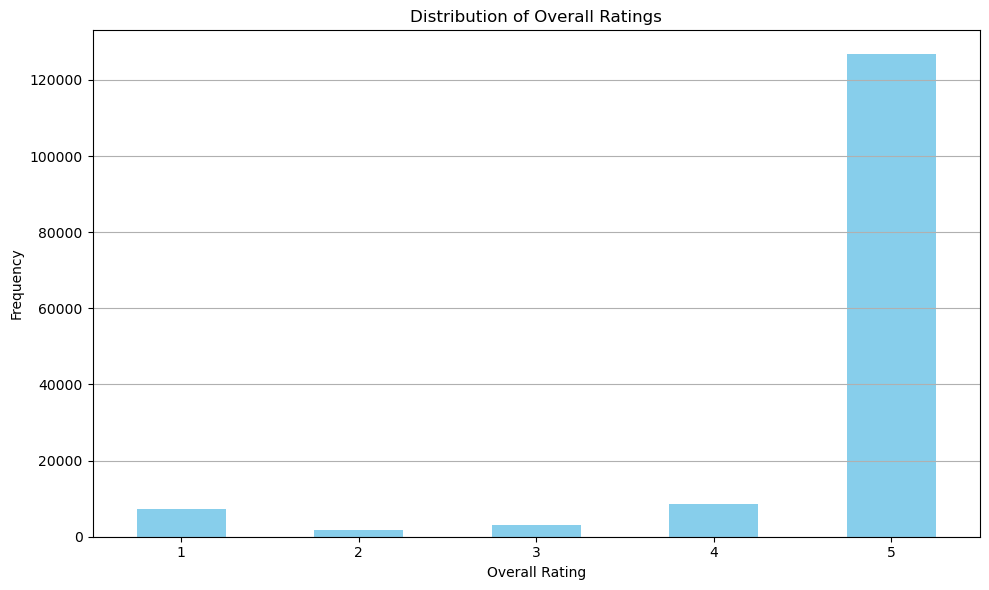

In [7]:
# Select numerical variables

# Print summary statistics
print("\nCounts and Averages of Overall:")
print(subset_data['overall'].describe())

# Plotting
plt.figure(figsize=(10, 6))
subset_data['overall'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Overall Ratings')
plt.xlabel('Overall Rating')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.grid(axis='y')  

plt.tight_layout()
plt.show()


#### Distribution of number of reviews across products

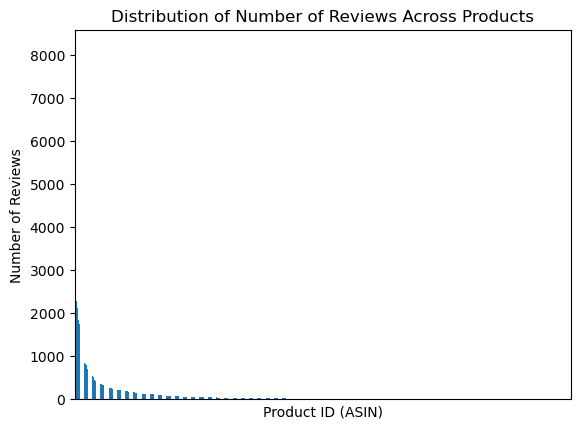

Maximum review count: 8174


In [8]:
# Calculate the number of reviews per product (ASIN)
review_counts = subset_data['asin'].value_counts()

# Create the plot
#plt.figure(figsize=(10, 4))
review_counts.plot(kind='bar')
plt.title('Distribution of Number of Reviews Across Products')
plt.xlabel('Product ID (ASIN)')
plt.ylabel('Number of Reviews')
plt.xticks([])  # Rotate the x-axis labels for better readability
plt.show()

review_counts = subset_data['asin'].value_counts()
max_review_count = review_counts.max()

print("Maximum review count:", max_review_count)


#### Distribution of number of reviews per products

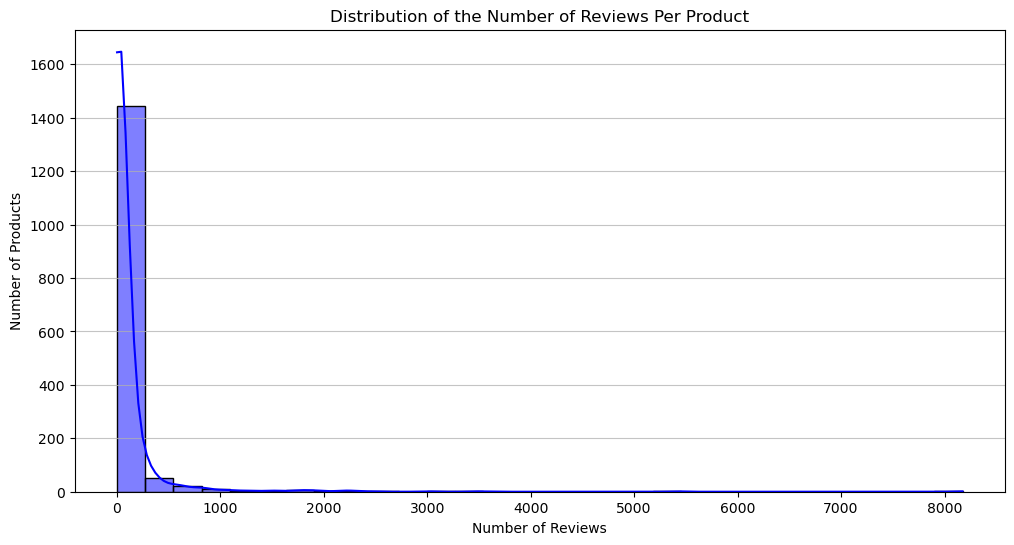

In [9]:
reviews_per_product = subset_data['asin'].value_counts()

# plot using seaborn
plt.figure(figsize=(12, 6))
sns.histplot(reviews_per_product, bins=30, kde=True, color='blue')
plt.title('Distribution of the Number of Reviews Per Product')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Products')
plt.grid(axis='y', alpha=0.75)

plt.show()


In [10]:
# Calculate the top 10 products with the most reviews and their counts
top_10_most_reviews = subset_data['asin'].value_counts().head(10)

print("Top 10 products with the most reviews:")
print(top_10_most_reviews)


Top 10 products with the most reviews:
asin
B004Q7CK9M    8174
B004LLIKVU    5420
B0091JKVU0    3486
B00JDQJZWG    2999
B0091JKY0M    2481
B014S24DAI    2293
B004LLIKY2    2234
B0066AZGD4    2223
B00H5BMH44    2131
B0091JL3OI    1946
Name: count, dtype: int64


In [11]:
max_asin = top_10_most_reviews.index[0]  # maximum review count product
max_asin_reviews = subset_data[subset_data['asin'] == max_asin]['reviewText']

print("Reviews for product with ASIN", max_asin, ":", max_asin_reviews)

Reviews for product with ASIN B004Q7CK9M : 25749    I bought this as a Christmas gift because I'm ...
24762                           was a gift, very happy....
30167    I find Amazon gift cards to be the best gift c...
30986    Amazon gift cards are great to give and receiv...
24540    Gift card comes in a good quality Christmas ca...
                               ...                        
24538                                   Grandson loves it!
30535    I asked my friends what gift they wanted and t...
26854    Great gift cards and the smile on the card tra...
24300                 Loved the card, loved the gift card.
23247    My son was happy to get this little gift card ...
Name: reviewText, Length: 8174, dtype: object


#### Distribution reviews per user

In [12]:
# Calculate the number of reviews per user
reviews_per_user = subset_data['reviewerID'].value_counts()

# Calculate the maximum, minimum, and average number of reviews per user
max_reviews_per_user = reviews_per_user.max()
min_reviews_per_user = reviews_per_user.min()
avg_reviews_per_user = reviews_per_user.mean()

print("Maximum number of reviews per user:", max_reviews_per_user)
print("Minimum number of reviews per user:", min_reviews_per_user)
print("Average number of reviews per user:", avg_reviews_per_user)


Maximum number of reviews per user: 39
Minimum number of reviews per user: 1
Average number of reviews per user: 1.1421277652335173


#### Review lengths

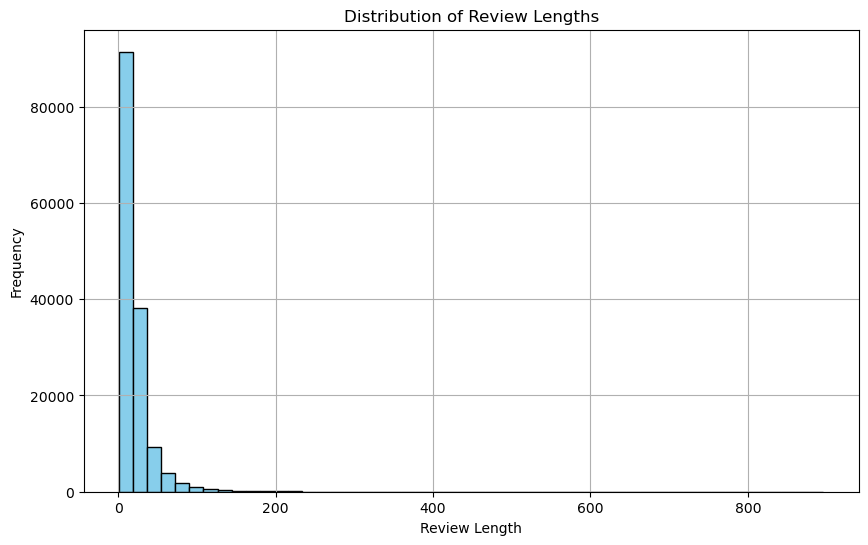

In [13]:
# Calculate review lengths
df_length = subset_data['reviewText'].dropna().apply(lambda x: len(str(x).split()))

# Plot histogram of review lengths
plt.figure(figsize=(10, 6))
plt.hist(df_length, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
# Calculate maximum, minimum, and average review lengths
max_review_length = df_length.max()
min_review_length = df_length.min()
avg_review_length = df_length.mean()


In [14]:
# review lengths
print("Minimum review length:", df_length.min())
print("Maximum review length:", df_length.max())
print("Average review length:", df_length.mean())

Minimum review length: 1
Maximum review length: 896
Average review length: 18.41667630156085


### b.2 Pre-processing

In [15]:
# Labeling the data based on ratings
def label_rating(row):
    if row['overall'] >= 4:
        return 'positive'
    elif row['overall'] == 3:
        return 'neutral'
    else:  # Ratings 1 and 2
        return 'negative'

subset_data['rating_label'] = subset_data.apply(label_rating, axis=1)

#### Chose the appropriate columns for your sentiment analyzer

In [16]:
# Dropping columns 'image', 'vote', and 'style' columns because are not important for the analysis
subset_data.drop(columns=['image', 'vote', 'style'], inplace=True, errors='ignore')


# Dropping 'overall' because'rating_label' will be used
subset_data.drop(columns=['overall'], inplace=True)

# Dropping columns that are not important for Sentiment analysis
subset_data.drop(columns=['reviewerName', 'reviewerID', 'asin', 'unixReviewTime', 'reviewTime' ], inplace=True)

# Chose the appropriate columns for your sentiment analyzer
subset_data['reviewText'] = subset_data['reviewText'].fillna('')
subset_data['summary'] = subset_data['summary'].fillna('')

# Combine 'reviewText' and 'summary' into a single column for a comprehensive sentiment analysis
subset_data['combined_text'] = subset_data['reviewText'] + " " + subset_data['summary']

subset_data.drop(columns=['reviewText', 'summary'], inplace=True, errors='ignore')

# Print the shape of the DataFrame to see the number of entries and columns
print("DataFrame shape:", subset_data.shape)

subset_data.head()

DataFrame shape: (147194, 3)


,verified,rating_label,combined_text
83758,True,neutral,Not much to really say about this other than i...
135602,True,positive,Ok Five Stars
65221,True,positive,Good Five Stars
39765,True,positive,The gift card was printed on line and we found...
2495,True,positive,I very much like the print-at-home Amazon gift...


In [17]:
# Print a summary of any missing values in the combined_text column
print("\nMissing values in 'combined_text':", subset_data['combined_text'].isnull().sum())



Missing values in 'combined_text': 0


#### Check for outliers

#### Unverified Reviewers outliers

In [18]:
def identify_unverified_reviewers(df):
    unverified_reviewers = df[df['verified'] == False]
    df = df.drop(unverified_reviewers.index)
    return len(unverified_reviewers)


unverified_reviewers_count = identify_unverified_reviewers(subset_data)
print("Number of Unverified Reviewers:", unverified_reviewers_count)


Number of Unverified Reviewers: 8957


In [19]:
# Delete unverified users reviews 
subset_data = subset_data[subset_data['verified'] != False]
subset_data.shape


(138237, 3)

In [20]:
# Drop column 'verified'
subset_data.drop(columns=['verified'], inplace=True, errors='ignore')
subset_data.shape

(138237, 2)

#### Word count outliers

Outlier threshold (Z-Score Method): 91.31244646736587


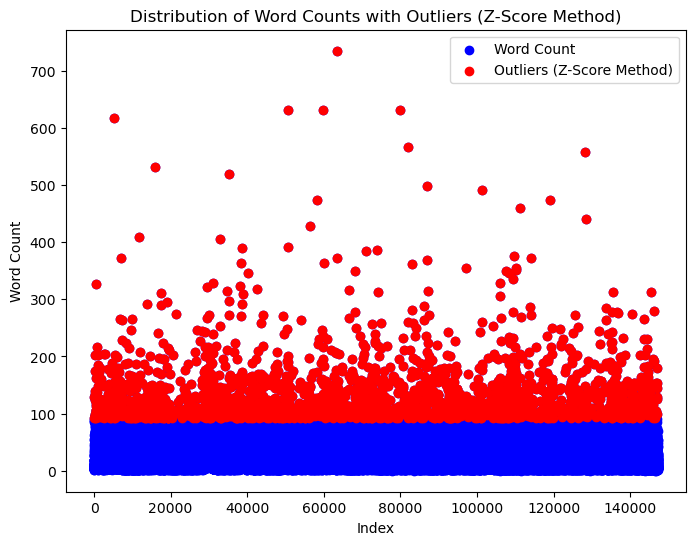

In [21]:
# Check for outliers in 'combined_text' by word count
subset_data['word_count'] = subset_data['combined_text'].fillna('').apply(lambda x: len(x.split()))

# Calculate z-scores
mean_length = subset_data['word_count'].mean()
std_length = subset_data['word_count'].std()

# Define threshold for outliers using z-scores
z_score_threshold = 3

# Print outlier threshold
outlier_threshold = mean_length + z_score_threshold * std_length
print("Outlier threshold (Z-Score Method):", outlier_threshold)

# Calculate z-scores for word count
wordcount_z_score = (subset_data['word_count'] - mean_length) / std_length

# Identify outliers using z-scores
outliers_z_score = subset_data['word_count'][(wordcount_z_score > z_score_threshold) | (wordcount_z_score < -z_score_threshold)]

# Create a scatter plot to visualize the distribution of review lengths and identify outliers using z-scores
plt.figure(figsize=(8, 6))
plt.scatter(subset_data['word_count'].index, subset_data['word_count'], c='blue', label='Word Count')
plt.scatter(outliers_z_score.index, outliers_z_score, c='red', label='Outliers (Z-Score Method)')
plt.xlabel('Index')
plt.ylabel('Word Count')
plt.title('Distribution of Word Counts with Outliers (Z-Score Method)')
plt.legend()
plt.show()

In [22]:
# Filter rows where word count is less than or equal to 89 to delete oouliers
subset_data = subset_data[subset_data['word_count'] <= outlier_threshold]

# Drop the 'word_count' column as it's no longer needed
subset_data.drop(columns=['word_count'], inplace=True)

# Optionally, you can reset the index of the DataFrame after dropping rows
subset_data.reset_index(drop=True, inplace=True)

subset_data.shape

(135947, 2)

In [23]:
subset_data.head()

,rating_label,combined_text
0,neutral,Not much to really say about this other than i...
1,positive,Ok Five Stars
2,positive,Good Five Stars
3,positive,The gift card was printed on line and we found...
4,positive,I very much like the print-at-home Amazon gift...


In [24]:
subset_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135947 entries, 0 to 135946
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   rating_label   135947 non-null  object
 1   combined_text  135947 non-null  object
dtypes: object(2)
memory usage: 2.1+ MB


#### Duplicates

In [25]:
# Find duplicates in the 'combined_text' column
duplicates_combinedText = subset_data[subset_data.duplicated(subset=['combined_text'], keep=False)]

# Count the number of duplicate rows based on specific columns
duplicate_count = duplicates_combinedText.shape[0]

print("Number of duplicate rows considering reviewerID, asin, unixReviewTime and reviewText:", duplicate_count)


Number of duplicate rows considering reviewerID, asin, unixReviewTime and reviewText: 24158


In [26]:
# Remove duplicates from subset_data based on the 'combined_text' column
subset_data = subset_data.drop_duplicates(subset=['combined_text'], keep='first')

# Verify the removal of duplicates
print("Number of rows after removing duplicates:", len(subset_data))


Number of rows after removing duplicates: 115622


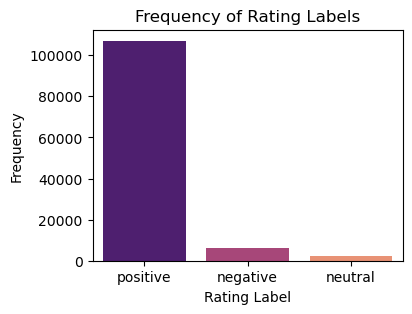

positive: 92.62%
negative: 5.28%
neutral: 2.11%
Shape of dataframe: (115622, 2)

Count Values
rating_label
positive    107085
negative      6103
neutral       2434
Name: count, dtype: int64


In [27]:
# Count the frequency of each rating label
label_counts = subset_data['rating_label'].value_counts()

# Calculate percentage of each rating label
label_percentage = label_counts / len(subset_data) * 100

# Plot the frequency of each rating label using seaborn
plt.figure(figsize=(4, 3))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='magma')
plt.title('Frequency of Rating Labels')
plt.xlabel('Rating Label')
plt.ylabel('Frequency')

plt.show()


# Print the percentage for each rating label
for label, percentage in zip(label_percentage.index, label_percentage.values):
    print(f"{label}: {percentage:.2f}%")
# Print shape of dataframe
print("Shape of dataframe:", subset_data.shape)
print("\nCount Values")
print(label_counts)


In [28]:
'''
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize the text data
tfidf_vectorizer = TfidfVectorizer(max_features=4000)  # You can adjust max_features as needed
X_tfidf = tfidf_vectorizer.fit_transform(subset_data['combined_text'])

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, subset_data['rating_label'])

# Convert the resampled data back to DataFrame
oversampled_data = pd.DataFrame({'rating_label': y_resampled, 'combined_text': X_resampled})

# Verify the new distribution
label_counts_oversampled = oversampled_data['rating_label'].value_counts()
label_percentage_oversampled = label_counts_oversampled / len(oversampled_data) * 100

# Plot the frequency of each rating label after oversampling
plt.figure(figsize=(4, 3))
sns.barplot(x=label_counts_oversampled.index, y=label_counts_oversampled.values, palette='magma')
plt.title('Frequency of Rating Labels after Oversampling')
plt.xlabel('Rating Label')
plt.ylabel('Frequency')
plt.show()

# Print the percentage for each rating label after oversampling
for label, percentage in zip(label_percentage_oversampled.index, label_percentage_oversampled.values):
    print(f"{label}: {percentage:.2f}%")
'''

'\nfrom imblearn.over_sampling import SMOTE\nfrom sklearn.feature_extraction.text import TfidfVectorizer\n\n# Vectorize the text data\ntfidf_vectorizer = TfidfVectorizer(max_features=4000)  # You can adjust max_features as needed\nX_tfidf = tfidf_vectorizer.fit_transform(subset_data[\'combined_text\'])\n\n# Apply SMOTE to balance the classes\nsmote = SMOTE(random_state=42)\nX_resampled, y_resampled = smote.fit_resample(X_tfidf, subset_data[\'rating_label\'])\n\n# Convert the resampled data back to DataFrame\noversampled_data = pd.DataFrame({\'rating_label\': y_resampled, \'combined_text\': X_resampled})\n\n# Verify the new distribution\nlabel_counts_oversampled = oversampled_data[\'rating_label\'].value_counts()\nlabel_percentage_oversampled = label_counts_oversampled / len(oversampled_data) * 100\n\n# Plot the frequency of each rating label after oversampling\nplt.figure(figsize=(4, 3))\nsns.barplot(x=label_counts_oversampled.index, y=label_counts_oversampled.values, palette=\'magma\'

In [29]:
min_count = min(label_counts['positive'], label_counts['negative'], label_counts['neutral'])

subset_balanced = pd.concat([
    subset_data[subset_data['rating_label'] == 'positive'].sample(min_count, random_state=42),
    subset_data[subset_data['rating_label'] == 'negative'].sample(min_count, random_state=42),
    subset_data[subset_data['rating_label'] == 'neutral']
])

subset_balanced = subset_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
subset_data = subset_balanced
print("Balanced class distribution:")
print(subset_balanced['rating_label'].value_counts())

Balanced class distribution:
rating_label
neutral     2434
negative    2434
positive    2434
Name: count, dtype: int64


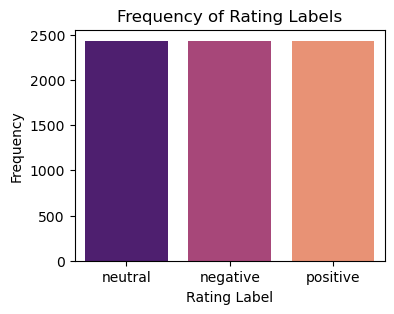

neutral: 33.33%
negative: 33.33%
positive: 33.33%
Shape of dataframe: (7302, 2)

Count Values
rating_label
neutral     2434
negative    2434
positive    2434
Name: count, dtype: int64


In [30]:
# Count the frequency of each rating label
label_counts = subset_data['rating_label'].value_counts()

# Calculate percentage of each rating label
label_percentage = label_counts / len(subset_data) * 100

# Plot the frequency of each rating label using seaborn
plt.figure(figsize=(4, 3))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='magma')
plt.title('Frequency of Rating Labels')
plt.xlabel('Rating Label')
plt.ylabel('Frequency')

plt.show()


# Print the percentage for each rating label
for label, percentage in zip(label_percentage.index, label_percentage.values):
    print(f"{label}: {percentage:.2f}%")
# Print shape of dataframe
print("Shape of dataframe:", subset_data.shape)
print("\nCount Values")
print(label_counts)

In [31]:
from nltk.tokenize import word_tokenize

# Define the list of stopwords and create the lemmatizer object
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Tokenize the text using NLTK
    tokens = word_tokenize(text)

    # Remove stopwords
#    tokens = [token for token in tokens if token.lower() not in stop_words]

    # Lemmatize each word
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back into text
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text


subset_data['reviews_after_preprocessing'] = subset_balanced['combined_text'].apply(preprocess_text)
subset_data['reviews_after_preprocessing'].head()

0    I purchased the gift card a a Father 's day pr...
1    Purchased a a gift for a friend . Delivery wa ...
2                         MY CODE WAS INVALID One Star
3                     I HAVE NEVER HAD ONE Three Stars
4    The card itself wa a scratched up so for gift ...
Name: reviews_after_preprocessing, dtype: object

### c. Split the data into 70% for training and 30% for testing,—Use stratified splitting based on the rating value field.

In [32]:
from sklearn.model_selection import StratifiedShuffleSplit

X = subset_data['reviews_after_preprocessing']
y = subset_data['rating_label']

# Create a StratifiedShuffleSplit object for the first split
split_initial = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

# Split the data into training/validation and test sets
for train_index, test_index in split_initial.split(X, y):
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print(X_train.head(20))
print(y_train.head(20))

(5111,) (5111,)
(2191,) (2191,)
4381    Came a described . The box it came in wa adora...
2542    very cute . The person who received the card l...
6119    Bait-and-switch : While browsing Amazon , I wa...
1576    Amazon gift card are the most requested gift i...
2895    Great for a 17 year old grandson . Gift for te...
7052    I give many Amazon gift card each year . Peopl...
6430    Not bad considering it wa free . You essential...
2907    Gift for my niece . She loved it because wa cu...
1083    Easy to process and send to recipient ! Five S...
604     Great looking tin , great for a gift . Male or...
3836    Given a a Christmas gift I guess it worked out...
3223    Everybody love to get an amazon gift card ! Bo...
4590    I gave these a christmas gift to my niece and ...
6198    I expected the recipient to be able to shop at...
259     What can you say , it 's a gift card . Really ...
1001    Card did n't even work what a waste of money ,...
2530    Great idea for kid to color gift

### d.	Represent the text using one of the text represtations discussed in the course, make sure to note in your report why you chose that representation.

In [34]:
from gensim.models import KeyedVectors
import numpy as np

# Function to load Word2Vec embeddings from file
def load_word2vec_embeddings(file_path):
    word2vec_model = KeyedVectors.load_word2vec_format(file_path, binary=True)
    return word2vec_model

# Load Word2Vec embeddings (example file path)
word2vec_file_path = r"C:\users\saman\Downloads\GoogleNews-vectors-negative300.bin" 
word2vec_embeddings = load_word2vec_embeddings(word2vec_file_path)

# Function to vectorize text using Word2Vec embeddings
def vectorize_text_with_word2vec(text, embeddings_model, embedding_dim):
    vectorized_text = []
    for sentence in text:
        sentence_vector = []
        for word in sentence.split():
            if word in embeddings_model:
                sentence_vector.append(embeddings_model[word])
        if sentence_vector:
            vectorized_text.append(np.mean(sentence_vector, axis=0))
        else:
            vectorized_text.append(np.zeros(embedding_dim))
    return np.array(vectorized_text)

# Assuming Word2Vec embeddings of dimension 300
embedding_dim = 300 

X_train_textr = vectorize_text_with_word2vec(X_train, word2vec_embeddings, embedding_dim)
X_test_textr = vectorize_text_with_word2vec(X_test, word2vec_embeddings, embedding_dim)

print("Shape of X_train_text:", X_train_textr.shape)
print("Shape of X_test_text:", X_test_textr.shape)



Shape of X_train_text: (5111, 300)
Shape of X_test_text: (2191, 300)


### e.	Build two sentiment analysis models using 70% of the data. Choose two of the following Machine Learning algorithms to build and fine tune your models:

#### Logistic Regression 

In [36]:
from sklearn.linear_model import LogisticRegression

# Build and fine-tune sentiment analysis models
# Model 1: Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train_textr, y_train)

# Make predictions on test data
y_pred_class = logreg.predict(X_test_textr)


C:\Users\saman\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [37]:
#Step 4: Evaluate the classifier using various measures

# Function to plot confusion matrix. 
# Ref:http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import numpy as np
import itertools
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)





Accuracy:  0.7608397991784573
AUC:  0.9021535954403598
Classification Report:
              precision    recall  f1-score   support

    negative       0.74      0.76      0.75       730
     neutral       0.67      0.69      0.68       730
    positive       0.87      0.83      0.85       731

    accuracy                           0.76      2191
   macro avg       0.76      0.76      0.76      2191
weighted avg       0.76      0.76      0.76      2191



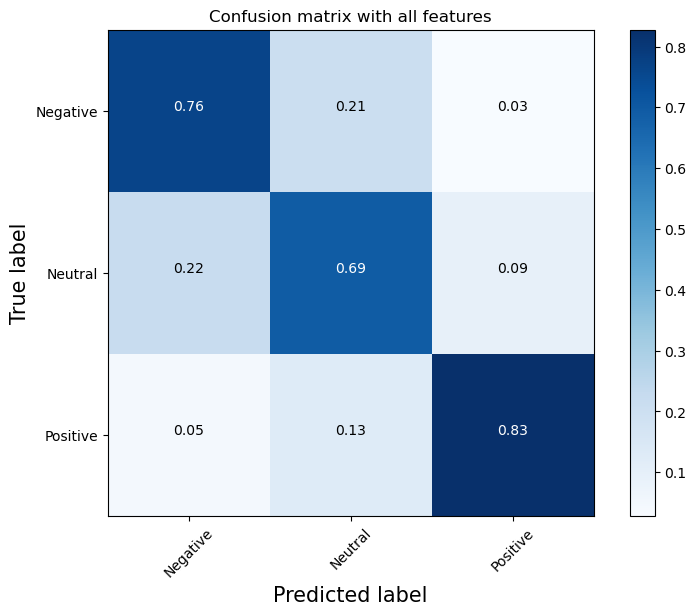

In [38]:
y_pred_prob = logreg.predict_proba(X_test_textr)

#calculate evaluation measuresfor Logistic Regression
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob, multi_class='ovr'))
# Other metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_class))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))

plot_confusion_matrix(cnf_matrix, classes=['Negative','Neutral', 'Positive'],normalize=True,
                      title='Confusion matrix with all features')

acc_lg_test = accuracy_score(y_test, y_pred_class)

#### Support Vector Machine (SVM):

Accuracy:  0.7713372889091739
AUC:  0.9100260197496493
Classification Report:
              precision    recall  f1-score   support

    negative       0.77      0.74      0.76       730
     neutral       0.67      0.72      0.70       730
    positive       0.88      0.85      0.87       731

    accuracy                           0.77      2191
   macro avg       0.77      0.77      0.77      2191
weighted avg       0.77      0.77      0.77      2191



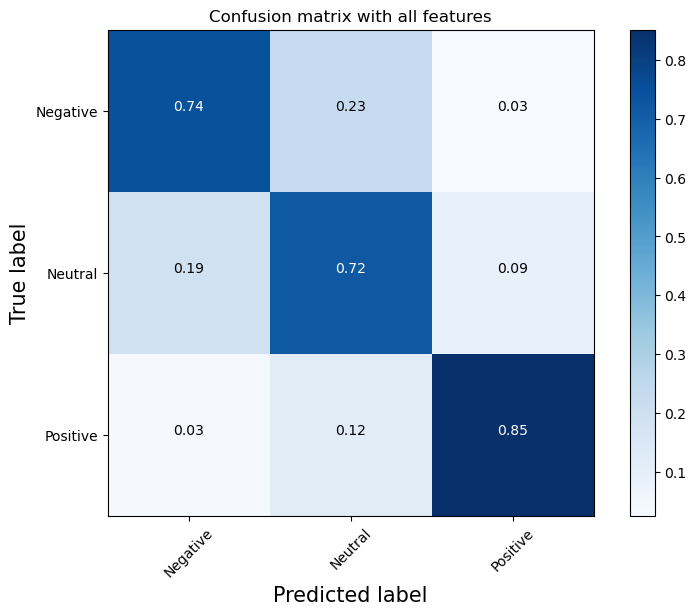

In [39]:
from sklearn.svm import SVC

# Instantiate the SVM model with 'rbf' kernel and class_weight='balanced'
svm = SVC(kernel='rbf',  probability=True)

# Fit the model with training data
svm.fit(X_train_textr, y_train)

# Make predictions on test data
y_pred_class = svm.predict(X_test_textr)

# Obtain predicted probabilities for each class
y_pred_prob = svm.predict_proba(X_test_textr)
acc_SVM_test = accuracy_score(y_test, y_pred_class)

# Calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob, multi_class='ovr'))

# Other metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_class))

# Plot confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Negative','Neutral', 'Positive'],normalize=True,
                      title='Confusion matrix with all features')

#### Naive Bayes:

Accuracy:  0.49748973071656777
AUC:  0.7055373708342222
Classification Report:
              precision    recall  f1-score   support

    negative       0.44      0.85      0.58       730
     neutral       0.56      0.15      0.24       730
    positive       0.61      0.49      0.54       731

    accuracy                           0.50      2191
   macro avg       0.54      0.50      0.46      2191
weighted avg       0.54      0.50      0.46      2191



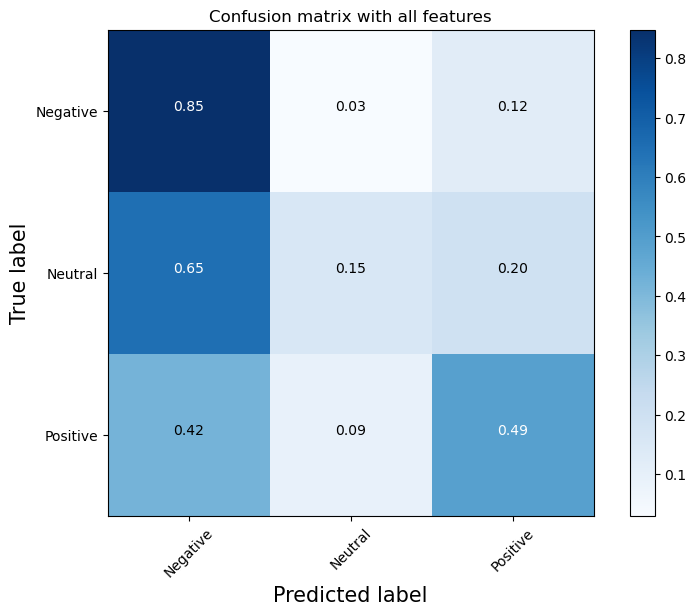

In [40]:

from sklearn.naive_bayes import GaussianNB

# Initialize Gaussian Naive Bayes classifier
gaussian_nb = GaussianNB()

# Train the model on the training data
gaussian_nb.fit(X_train_textr, y_train)

# Predict sentiment labels for the testing data
y_pred_class = gaussian_nb.predict(X_test_textr)

# Obtain predicted probabilities for each class
y_pred_prob = gaussian_nb.predict_proba(X_test_textr)
acc_NB_test = accuracy_score(y_test, y_pred_class)

#calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob, multi_class='ovr'))
# Other metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_class))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))

plot_confusion_matrix(cnf_matrix, classes=['Negative','Neutral', 'Positive'],normalize=True,
                      title='Confusion matrix with all features')

#### Gradient Boosting: 

Accuracy:  0.7165677772706527
AUC:  0.8811895811941602
Classification Report:
              precision    recall  f1-score   support

    negative       0.71      0.72      0.71       730
     neutral       0.63      0.62      0.62       730
    positive       0.81      0.81      0.81       731

    accuracy                           0.72      2191
   macro avg       0.72      0.72      0.72      2191
weighted avg       0.72      0.72      0.72      2191



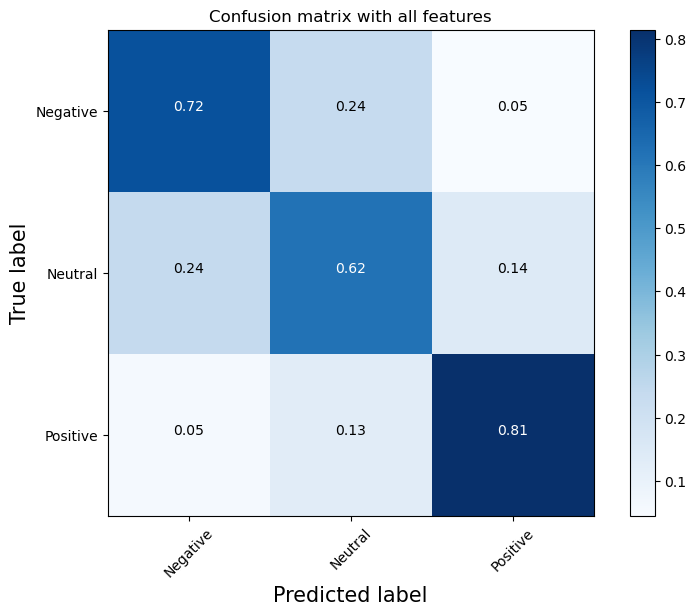

In [41]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the Gradient Boosting model
gradient_boosting = GradientBoostingClassifier()

# Train the model on the training data
gradient_boosting.fit(X_train_textr, y_train)

# Predict sentiment labels for the testing data
y_pred_class = gradient_boosting.predict(X_test_textr)

# Obtain predicted probabilities for each class
y_pred_prob = gradient_boosting.predict_proba(X_test_textr)
acc_GB_test = accuracy_score(y_test, y_pred_class)

#calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob, multi_class='ovr'))
# Other metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_class))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))

plot_confusion_matrix(cnf_matrix, classes=['Negative','Neutral', 'Positive'],normalize=True,
                      title='Confusion matrix with all features')



#### Multi-layer Perceptron (MLP):

C:\Users\saman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy:  0.762665449566408
AUC:  0.9095545304327617
Classification Report:
              precision    recall  f1-score   support

    negative       0.76      0.75      0.76       730
     neutral       0.67      0.70      0.69       730
    positive       0.86      0.84      0.85       731

    accuracy                           0.76      2191
   macro avg       0.76      0.76      0.76      2191
weighted avg       0.76      0.76      0.76      2191



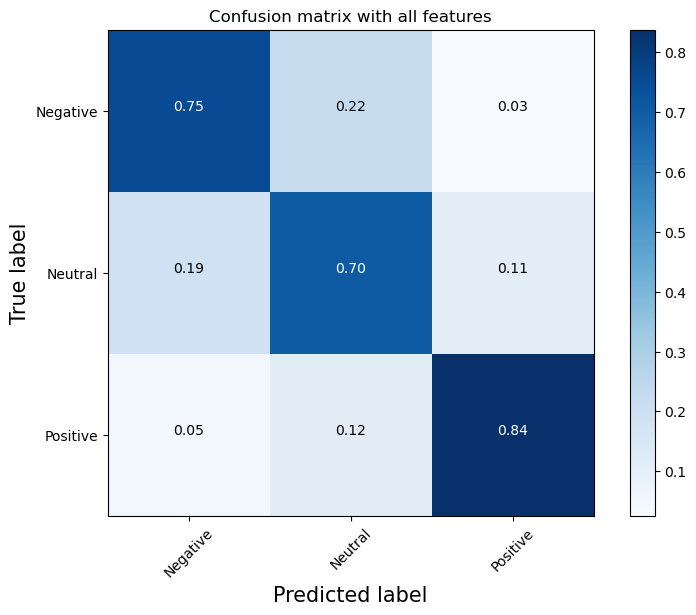

In [42]:
from sklearn.neural_network import MLPClassifier

# Initialize the MLP model
mlp_model = MLPClassifier()

# Train the model on the training data
mlp_model.fit(X_train_textr, y_train)

# Predict sentiment labels for the testing data
y_pred_class = mlp_model.predict(X_test_textr)

# Obtain predicted probabilities for each class
y_pred_prob = mlp_model.predict_proba(X_test_textr)
acc_MLP_test = accuracy_score(y_test, y_pred_class)

#calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob, multi_class='ovr'))
# Other metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_class))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))

plot_confusion_matrix(cnf_matrix, classes=['Negative','Neutral', 'Positive'],normalize=True,
                      title='Confusion matrix with all features')

In [43]:
print('\n=========================================')
print('ACCURACY OF MODELS WITH DATASET TESTING')
print("Accuracy Logistic Regresion: {:.2%}".format(acc_lg_test))
print("Accuracy SVM Model: {:.2%}".format(acc_SVM_test))
print("Accuracy Naive Bayes Model: {:.2%}".format(acc_NB_test))
print("Accuracy Gradient Boosting: {:.2%}".format(acc_GB_test))
print("Accuracy MLP: {:.2%}".format(acc_MLP_test))


ACCURACY OF MODELS WITH DATASET TESTING
Accuracy Logistic Regresion: 76.08%
Accuracy SVM Model: 77.13%
Accuracy Naive Bayes Model: 49.75%
Accuracy Gradient Boosting: 71.66%
Accuracy MLP: 76.27%


In [44]:
# Test texts
test_texts = [
    "This product is amazing!",
    "It is not bad",
    "I hate this product, it's terrible",
    " xxxx", 
    "This product is great!",
    "so so",
    "This product is not bad, but it could be better"
]

y_texts = [   
    "positive",
    "neutral",
    "negative",
    "neutral", 
    "positive",
    "neutral",
    "neutral"
    ]
# Preprocess the test texts
preprocessed_test_texts = [preprocess_text(text) for text in test_texts]

# Vectorize the preprocessed test texts using Word2vec
X_test_vectorized = vectorize_text_with_word2vec(preprocessed_test_texts, word2vec_embeddings, embedding_dim)

# Test Logistic Regression model
print("Logistic Regression Model:")
# Make predictions
y_pred_logreg = logreg.predict(X_test_vectorized)
print("Predictions:", y_pred_logreg)
# Calculate accuracy
accuracy_logreg = accuracy_score(y_texts, y_pred_logreg)
print("Accuracy Logistic Regresion:", accuracy_logreg)

# Test SVM model
print("\nSVM Model:")
# Make predictions
y_pred_svm = svm.predict(X_test_vectorized)
print("Predictions:", y_pred_svm)
# Calculate accuracy
accuracy_svm = accuracy_score(y_texts, y_pred_svm)
print("Accuracy SVM Model:", accuracy_svm)

# Test Naive Bayes model
print("\nNaive Bayes Model:")
# Make predictions
y_pred_naive_bayes = gaussian_nb.predict(X_test_vectorized)
print("Predictions:", y_pred_naive_bayes)
# Calculate accuracy
accuracy_naive_bayes = accuracy_score(y_texts, y_pred_naive_bayes)
print("Accuracy Naive Bayes Model:", accuracy_naive_bayes)

# Test Gradient Boosting model
print("\nGradient Boosting Model:")
# Make predictions
y_pred_gradient_boosting = gradient_boosting.predict(X_test_vectorized)
print("Predictions:", y_pred_gradient_boosting)
# Calculate accuracy
accuracy_gradient_boosting = accuracy_score(y_texts, y_pred_gradient_boosting)
print("Accuracy Gradient Boosting:", accuracy_gradient_boosting)

# Test MLP model
print("\nMLP Model:")
# Make predictions
y_pred_mlp = mlp_model.predict(X_test_vectorized)
print("Predictions:", y_pred_mlp)
# Calculate accuracy
accuracy_mlp = accuracy_score(y_texts, y_pred_mlp)
print("Accuracy MLP:", accuracy_mlp)


import pickle
# Load the VADER model from the file
with open("vader_model_part1.pkl", 'rb') as f:
    vader_model = pickle.load(f)
      
# Test VADER model
print("VADER Model:")
y_pred_vader = []
for text in preprocessed_test_texts:
    score = vader_model.polarity_scores(text)['compound']
    if score > 0:
        print("positive")
        y_pred_vader.append('positive')
    elif score < 0:
        print("negative")
        y_pred_vader.append('negative')
    else:
        print("neutral")
        y_pred_vader.append('neutral')


# Calculate accuracy
accuracy_vader = accuracy_score(y_texts, y_pred_vader)
print("Accuracy VADER:", accuracy_vader)

Logistic Regression Model:
Predictions: ['positive' 'negative' 'negative' 'positive' 'positive' 'neutral'
 'neutral']
Accuracy Logistic Regresion: 0.7142857142857143

SVM Model:
Predictions: ['positive' 'negative' 'negative' 'positive' 'positive' 'neutral'
 'neutral']
Accuracy SVM Model: 0.7142857142857143

Naive Bayes Model:
Predictions: ['positive' 'positive' 'neutral' 'positive' 'positive' 'positive'
 'negative']
Accuracy Naive Bayes Model: 0.2857142857142857

Gradient Boosting Model:
Predictions: ['positive' 'neutral' 'neutral' 'neutral' 'positive' 'neutral' 'negative']
Accuracy Gradient Boosting: 0.7142857142857143

MLP Model:
Predictions: ['positive' 'negative' 'negative' 'positive' 'positive' 'positive'
 'negative']
Accuracy MLP: 0.42857142857142855
VADER Model:
positive
positive
negative
neutral
positive
neutral
positive
Accuracy VADER: 0.7142857142857143


In [45]:
#COMPARE ACCUARACY
print('\n=========================================')
print("Accuracy Logistic Regresion: {:.2%}".format(accuracy_logreg))
print("Accuracy SVM Model: {:.2%}".format(accuracy_svm))
print("Accuracy Naive Bayes Model: {:.2%}".format(accuracy_naive_bayes))
print("Accuracy Gradient Boosting: {:.2%}".format(accuracy_gradient_boosting))
print("Accuracy MLP: {:.2%}".format(accuracy_mlp))
print("Accuracy VADER: {:.2%}".format(accuracy_vader))


Accuracy Logistic Regresion: 71.43%
Accuracy SVM Model: 71.43%
Accuracy Naive Bayes Model: 28.57%
Accuracy Gradient Boosting: 71.43%
Accuracy MLP: 42.86%
Accuracy VADER: 71.43%


In [46]:
""" 16. a.Enhance the rating values """
from sklearn.metrics import mean_squared_error

X_enhance = X_test[:100]  
y_enhance = y_test[:100]

def enhanced_rating(X_enhance, y_enhance):
    
    sentiment_lr = logreg.predict(X_enhance)
    sentiment_svm = svm.predict(X_enhance)
    
    # Mapear etiquetas de sentimiento a valores numéricos
    sentiment_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
    sentiment_lr_numeric = np.array([sentiment_mapping[label] for label in sentiment_lr])
    sentiment_svm_numeric = np.array([sentiment_mapping[label] for label in sentiment_svm])
    y_enhance_numeric = np.array([sentiment_mapping[label] for label in y_enhance])

    best_weights = None
    lowest_mse = float('inf')


    # Grid search for weights
    for alpha in range(0, 11):
        lg_weight = alpha / 10
        svm_weight = 1 - lg_weight
        
        # Combine predictions using a linear combination
        enhanced_rating = np.multiply(lg_weight, sentiment_lr_numeric) + np.multiply(svm_weight, 1 - sentiment_svm_numeric)
        
        # Calculate MSE
        mse = mean_squared_error(y_enhance_numeric, enhanced_rating)
        
        # Check if this MSE is the lowest found so far
        if mse < lowest_mse:
            lowest_mse = mse
            best_weights = (lg_weight, svm_weight)
    
    enhanced_rating = (best_weights[0] * sentiment_lr_numeric) + (best_weights[1] * (1 - sentiment_svm_numeric))

    final_results = pd.DataFrame()
    final_results["actual_rating"] = y_enhance_numeric 
    final_results["enhanced_rating"] = enhanced_rating.round().astype(int)

    return final_results


X_enhance = vectorize_text_with_word2vec(X_enhance, word2vec_embeddings, embedding_dim)
final_test_results = enhanced_rating(X_enhance, y_enhance)

def map_rating_to_category(rating):
    if rating == 2:
        return "Positive"
    elif rating == 1:
        return "Neutral"
    else:
        return "Negative"

total_records = len(final_test_results)
same_count = 0


print("\nRecords where enhanced rating differs from actual rating:\n")
for index in final_test_results.index:
    if final_test_results.at[index, "actual_rating"] == final_test_results.at[index, "enhanced_rating"]:
        same_count += 1
    else:
        actual_category = map_rating_to_category(final_test_results.at[index, "actual_rating"])
        enhanced_category = map_rating_to_category(final_test_results.at[index, "enhanced_rating"])
        print("Actual Rating:", actual_category)
        print("Enhanced Rating:", enhanced_category)

different_count = total_records - same_count
accuracy = (same_count / total_records) * 100

print("\nSame Rating: {:.2f}%".format(accuracy))
print("Same Ratings Count:", same_count)
print("Different Ratings Count:", different_count)


Records where enhanced rating differs from actual rating:

Actual Rating: Negative
Enhanced Rating: Neutral
Actual Rating: Negative
Enhanced Rating: Neutral
Actual Rating: Neutral
Enhanced Rating: Positive
Actual Rating: Negative
Enhanced Rating: Neutral
Actual Rating: Negative
Enhanced Rating: Neutral
Actual Rating: Negative
Enhanced Rating: Neutral
Actual Rating: Neutral
Enhanced Rating: Negative
Actual Rating: Neutral
Enhanced Rating: Positive
Actual Rating: Positive
Enhanced Rating: Neutral
Actual Rating: Negative
Enhanced Rating: Neutral
Actual Rating: Neutral
Enhanced Rating: Positive
Actual Rating: Neutral
Enhanced Rating: Negative
Actual Rating: Negative
Enhanced Rating: Neutral
Actual Rating: Neutral
Enhanced Rating: Negative
Actual Rating: Neutral
Enhanced Rating: Negative
Actual Rating: Neutral
Enhanced Rating: Positive
Actual Rating: Negative
Enhanced Rating: Neutral
Actual Rating: Negative
Enhanced Rating: Neutral

Same Rating: 82.00%
Same Ratings Count: 82
Different Rati

In [47]:
""" 16. a.Enhance the rating values """
from sklearn.metrics import mean_squared_error

X_enhance = X_test[:100]  
y_enhance = y_test[:100]

def enhanced_rating(X_enhance, y_enhance):
    
    sentiment_lr = logreg.predict(X_enhance)
    sentiment_svm = gradient_boosting.predict(X_enhance)
    
    # Mapear etiquetas de sentimiento a valores numéricos
    sentiment_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
    sentiment_lr_numeric = np.array([sentiment_mapping[label] for label in sentiment_lr])
    sentiment_svm_numeric = np.array([sentiment_mapping[label] for label in sentiment_svm])
    y_enhance_numeric = np.array([sentiment_mapping[label] for label in y_enhance])

    best_weights = None
    lowest_mse = float('inf')


    # Grid search for weights
    for alpha in range(0, 11):
        lg_weight = alpha / 10
        svm_weight = 1 - lg_weight
        
        # Combine predictions using a linear combination
        enhanced_rating = np.multiply(lg_weight, sentiment_lr_numeric) + np.multiply(svm_weight, 1 - sentiment_svm_numeric)
        
        # Calculate MSE
        mse = mean_squared_error(y_enhance_numeric, enhanced_rating)
        
        # Check if this MSE is the lowest found so far
        if mse < lowest_mse:
            lowest_mse = mse
            best_weights = (lg_weight, svm_weight)
    
    enhanced_rating = (best_weights[0] * sentiment_lr_numeric) + (best_weights[1] * (1 - sentiment_svm_numeric))

    final_results = pd.DataFrame()
    final_results["actual_rating"] = y_enhance_numeric 
    final_results["enhanced_rating"] = enhanced_rating.round().astype(int)

    return final_results


X_enhance = vectorize_text_with_word2vec(X_enhance, word2vec_embeddings, embedding_dim)
final_test_results = enhanced_rating(X_enhance, y_enhance)

def map_rating_to_category(rating):
    if rating == 2:
        return "Positive"
    elif rating == 1:
        return "Neutral"
    else:
        return "Negative"

total_records = len(final_test_results)
same_count = 0


print("\nRecords where enhanced rating differs from actual rating:\n")
for index in final_test_results.index:
    if final_test_results.at[index, "actual_rating"] == final_test_results.at[index, "enhanced_rating"]:
        same_count += 1
    else:
        actual_category = map_rating_to_category(final_test_results.at[index, "actual_rating"])
        enhanced_category = map_rating_to_category(final_test_results.at[index, "enhanced_rating"])
        print("Actual Rating:", actual_category)
        print("Enhanced Rating:", enhanced_category)

different_count = total_records - same_count
accuracy = (same_count / total_records) * 100

print("\nSame Rating: {:.2f}%".format(accuracy))
print("Same Ratings Count:", same_count)
print("Different Ratings Count:", different_count)


Records where enhanced rating differs from actual rating:

Actual Rating: Negative
Enhanced Rating: Neutral
Actual Rating: Negative
Enhanced Rating: Neutral
Actual Rating: Neutral
Enhanced Rating: Positive
Actual Rating: Negative
Enhanced Rating: Neutral
Actual Rating: Negative
Enhanced Rating: Neutral
Actual Rating: Negative
Enhanced Rating: Neutral
Actual Rating: Neutral
Enhanced Rating: Negative
Actual Rating: Neutral
Enhanced Rating: Positive
Actual Rating: Positive
Enhanced Rating: Neutral
Actual Rating: Negative
Enhanced Rating: Neutral
Actual Rating: Neutral
Enhanced Rating: Positive
Actual Rating: Neutral
Enhanced Rating: Negative
Actual Rating: Negative
Enhanced Rating: Neutral
Actual Rating: Neutral
Enhanced Rating: Negative
Actual Rating: Neutral
Enhanced Rating: Negative
Actual Rating: Neutral
Enhanced Rating: Positive
Actual Rating: Negative
Enhanced Rating: Neutral
Actual Rating: Negative
Enhanced Rating: Neutral

Same Rating: 82.00%
Same Ratings Count: 82
Different Rati

## Using a LLM model summarize the results into a 50 word. 

In [51]:
import pandas as pd
import spacy
import random
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from transformers import BartForConditionalGeneration, BartTokenizer
# Load the pre-trained GPT-2 model for summarization
#summarization_pipeline = pipeline("summarization")

#Load data
df = pd.read_json(r"C:\Users\saman\Downloads\Gift_Cards.json\Gift_Cards.json",lines = True)

# Select a Subset of Data
subset_data = df.sample(n=8000, random_state=42)


# Labeling the data based on ratings
def label_rating(row):
    if row['overall'] >= 4:
        return 'positive'
    elif row['overall'] == 3:
        return 'neutral'
    else:  # Ratings 1 and 2
        return 'negative'

subset_data['rating_label'] = subset_data.apply(label_rating, axis=1)

# Dropping columns 'image', 'vote', and 'style' columns because are not important for the analysis
subset_data.drop(columns=['image', 'vote', 'style'], inplace=True, errors='ignore')

# Dropping 'overall' because'rating_label' will be used
subset_data.drop(columns=['overall'], inplace=True)

# Dropping columns that are not important for Sentiment analysis
subset_data.drop(columns=['reviewerName', 'reviewerID', 'asin', 'unixReviewTime', 'reviewTime' ], inplace=True)

# Chose the appropriate columns for your sentiment analyzer
subset_data['reviewText'] = subset_data['reviewText'].fillna('')

subset_data.drop(columns=['summary'], inplace=True, errors='ignore')

def identify_unverified_reviewers(df):
    unverified_reviewers = df[df['verified'] == False]
    df = df.drop(unverified_reviewers.index)
    return len(unverified_reviewers)

unverified_reviewers_count = identify_unverified_reviewers(subset_data)

# Delete unverified users reviews 
subset_data = subset_data[subset_data['verified'] != False]
subset_data.shape

# Drop column 'verified'
subset_data.drop(columns=['verified'], inplace=True, errors='ignore')
subset_data.shape

# Find duplicates in the 'reviewText' column
duplicates_combinedText = subset_data[subset_data.duplicated(subset=['reviewText'], keep=False)]

# Count the number of duplicate rows based on specific columns
duplicate_count = duplicates_combinedText.shape[0]

print("Number of duplicate rows considering reviewText:", duplicate_count)

# Remove duplicates from subset_data based on the 'reviewText' column
subset_data = subset_data.drop_duplicates(subset=['reviewText'], keep='first')

subset_data.info()

# Verify the removal of duplicates
print("Number of rows after removing duplicates:", len(subset_data))


"""
Summary
"""
# Select 10 reviews with lengths more than 100 words
selected_reviews = subset_data[subset_data['reviewText'].str.split().apply(len) > 100]
print("Number of reviews with more tha 100 words: ",selected_reviews.shape)

selected_reviews.loc[:, 'word_count'] = selected_reviews['reviewText'].str.split().apply(len)

#selected_reviews['word_count'] = selected_reviews['reviewText'].str.split().apply(len)
print(selected_reviews[['reviewText', 'word_count']])


# Randomly select 10 reviews from the subset
selected_reviews = selected_reviews.sample(n=10, random_state=42)


# Load BART model and tokenizer
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

# Ensure each review is a string in a list
reviews = selected_reviews['reviewText'].tolist()

# Truncate or pad the input sequences to a maximum length of 512 tokens
encoded_inputs = tokenizer(reviews, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Generate summaries
# Generate summaries
summary_ids = model.generate(encoded_inputs.input_ids, num_beams=4, max_length=50, min_length=40)

# Decode the summaries
summaries = [tokenizer.decode(summary_id, skip_special_tokens=True) for summary_id in summary_ids]

# Print summaries for the first two reviews
for i in range(2):
    print('\n===============================================')
    print(f"Original text for review {i+1}: {reviews[i]}")
    print('\n===============================================')
    print(f"Summary for review {i+1}: {summaries[i]}")



Number of duplicate rows considering reviewText: 898
<class 'pandas.core.frame.DataFrame'>
Index: 6826 entries, 83758 to 22946
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   reviewText    6826 non-null   object
 1   rating_label  6826 non-null   object
dtypes: object(2)
memory usage: 160.0+ KB
Number of rows after removing duplicates: 6826
Number of reviews with more tha 100 words:  (83, 2)
                                               reviewText  word_count
25749   I bought this as a Christmas gift because I'm ...         121
78123   There are many ways to put a smile on your dau...         154
104323  My husband and I were trying to figure out wha...         123
116100  all 4 gift "cards" were received. the experien...         151
811     I had ordered over $200.00 of Regal movie card...         110
...                                                   ...         ...
109343  DO NOT BUY THIS CRAP! I am so incr

C:\Users\saman\AppData\Local\Temp\ipykernel_20604\1466008649.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_reviews.loc[:, 'word_count'] = selected_reviews['reviewText'].str.split().apply(len)


C:\Users\saman\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\saman\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


ImportError: 
BartForConditionalGeneration requires the PyTorch library but it was not found in your environment.
However, we were able to find a TensorFlow installation. TensorFlow classes begin
with "TF", but are otherwise identically named to our PyTorch classes. This
means that the TF equivalent of the class you tried to import would be "TFBartForConditionalGeneration".
If you want to use TensorFlow, please use TF classes instead!

If you really do want to use PyTorch please go to
https://pytorch.org/get-started/locally/ and follow the instructions that
match your environment.


## Using a LLM model to create a response as a service representatitive

In [52]:
"""
Answering Question
"""    

# Load English language model for spaCy
nlp = spacy.load("en_core_web_sm")

# Function to check if a sentence is a question
def is_question(sentence):
    # Tokenize the sentence
    doc = nlp(sentence)
    
    # Check if the last token is a question mark and the sentence starts with a question word or auxiliary verb
    if len(doc) <= 30 and doc[-1].text == "?" and (doc[0].tag_ == "WDT" or doc[0].tag_ == "WRB" or doc[0].tag_ == "WP" or doc[0].tag_ == "MD"):
        return True
    else:
        return False

# Filter rows containing questions
questions_df = subset_data[subset_data['reviewText'].apply(is_question)]

# Print the questions
print("Questions in the dataset:")
print(questions_df['reviewText'])

# Generate a random integer between 0 and 9 (inclusive)
random_index = random.randint(0, len(questions_df) - 1)
# question_review = questions_df['reviewText'].iloc[random_index]

question_review = questions_df['reviewText'].iloc[random_index]

# Load the language model pipeline
model_name = "gpt2"  
lm_tokenizer = GPT2Tokenizer.from_pretrained(model_name)
lm_model = GPT2LMHeadModel.from_pretrained(model_name)

# Tokenize the input text
inputs = lm_tokenizer.encode(question_review, return_tensors="pt")

# Generate the output
outputs = lm_model.generate(inputs, max_length=50, num_return_sequences=1)

# Decode and print the generated text
generated_response = lm_tokenizer.decode(outputs[0], skip_special_tokens=True)
print('\n===============================================')
print("Original question:", question_review)
print("Generated response:", generated_response)

IndexError: [E040] Attempt to access token at -1, max length 0.